# Fingrid power visualizer

Visualization of current power production and consumption in the main power grid in Finland. Power production and consumption are furthermore divided into distinct factors as provided by the Fingrid API. Data is based on the real time data (updated once per three minutes) but the database and notebook is updated once per hour.


Data source: Fingrid / data.fingrid.fi, license CC 4.0 BY

In [1]:
import psycopg2 as pg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

import sys
import os

if os.getcwd().split('/')[-1] != 'power':
    os.chdir("..")
sys.path.insert(0, os.getcwd())
from configuration.config import config

In [2]:
# Establish database connection and retrieve data
params = config()
conn = pg2.connect(**params)
cur = conn.cursor()

cur.execute('''
            SELECT tpc.time_utc, tpc.time_local, total_production, total_consumption, 
            production_surplus_deficit, net_import_export, wind_production, other_production, 
            industrial_cogeneration, cogeneration_district_heating, nuclear_power, 
            hydro_power, sweden_aland, finland_central_sweden, finland_norway, finland_russia,
            finland_northern_sweden, finland_estonia
            FROM total_prod_consum AS tpc
            INNER JOIN import_export_surplus_deficit AS iesd ON tpc.time_local=iesd.time_local
            INNER JOIN production_sources AS ps ON iesd.time_local=ps.time_local
            INNER JOIN transmission_between_countries AS tbc ON ps.time_local=tbc.time_local
            ''')

data=cur.fetchall()
conn.close()

In [3]:
# Create dataframe
df = pd.DataFrame(data=data, columns=[
    "time_utc", 
    "time_local", 
    "power_production", 
    "power_consumption",
    "production_surplus_deficit",
    "net_import_export", 
    "wind_production", 
    "other_production", 
    "industrial_cogeneration", 
    "cogeneration_district_heating", 
    "nuclear_power", 
    "hydro_power", 
    "aland_sweden", 
    "central_sweden", 
    "norway", 
    "russia",
    "northern_sweden", 
    "estonia"
])

In [4]:
country_columns=[
    "aland_sweden", 
    "central_sweden", 
    "norway", 
    "russia",
    "northern_sweden", 
    "estonia"]

source_columns=[
    "wind_production", 
    "other_production", 
    "industrial_cogeneration", 
    "cogeneration_district_heating", 
    "nuclear_power", 
    "hydro_power"]

aggregate_columns=[
    "power_production", 
    "power_consumption",
    "production_surplus_deficit",
    "net_import_export"
]

# Convert from object to float
df.iloc[:,2:] = df.iloc[:,2:].astype(float)

In [5]:
# Select last n days 
days = 7
cutoff_date = df["time_local"].iloc[-1] - pd.Timedelta(days=days)
df = df[df['time_local'] > cutoff_date]

In [6]:
# Set styles
sns.set(font_scale=1.2,style='whitegrid')
font_size=14

## Total production and consumption in the main grid

Two figures below visualize the total production and consumption of electric power in the main grid as well as the difference between these two. Figures indicate that the difference is continuously positive which means that production does not cover all the consumption and the difference is covered by importing power from neighboring countries. In figures below date tick marks the change of day.

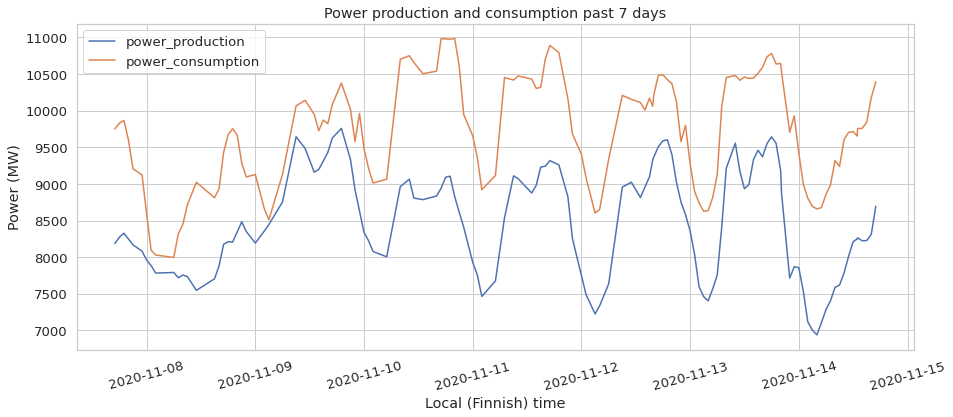

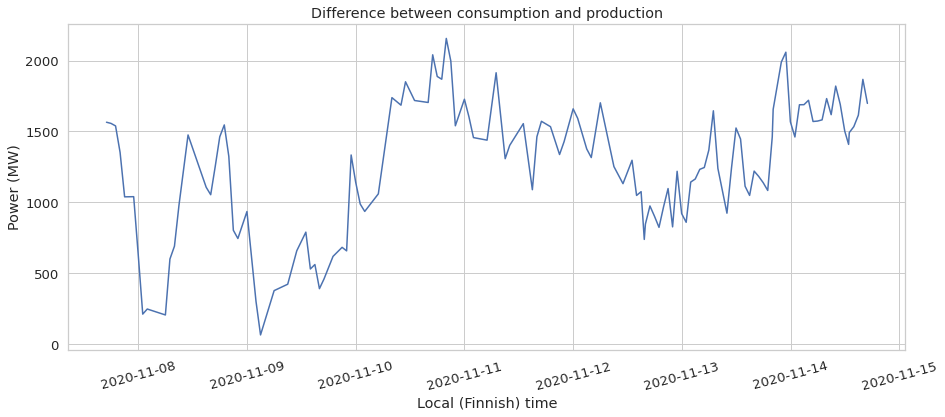

In [7]:
df2 = pd.melt(df, id_vars=['time_local'], value_vars=['power_production', 'power_consumption'])

plt.figure(figsize=(15,6))
ax = sns.lineplot(x='time_local', y='value', hue='variable', data=df2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
ax.set(xlabel='Local (Finnish) time', ylabel='Power (MW)')
plt.xticks(rotation=15)
plt.title('Power production and consumption past '+str(days)+' days')
plt.show()

df2 = df.copy()
df2['consum_prod_diff']=df2['power_consumption']-df2['power_production']
plt.figure(figsize=(15,6))
ax = sns.lineplot(x='time_local', y='consum_prod_diff', data=df2)
ax.set(xlabel='Local (Finnish) time', ylabel='Power (MW)')
plt.xticks(rotation=15)
plt.title('Difference between consumption and production')
plt.show()

## Imported and exported power in the main grid

Production deficit/surplus, e.g. the difference between production and consumption, is covered by importing/exporting power to and from neighboring countries. Figure below indicates the power exchange in the main grid of Finland between Sweden, Russia, Estonia and Norway. Also the power exchange between Åland and Sweden is included in the figure. 




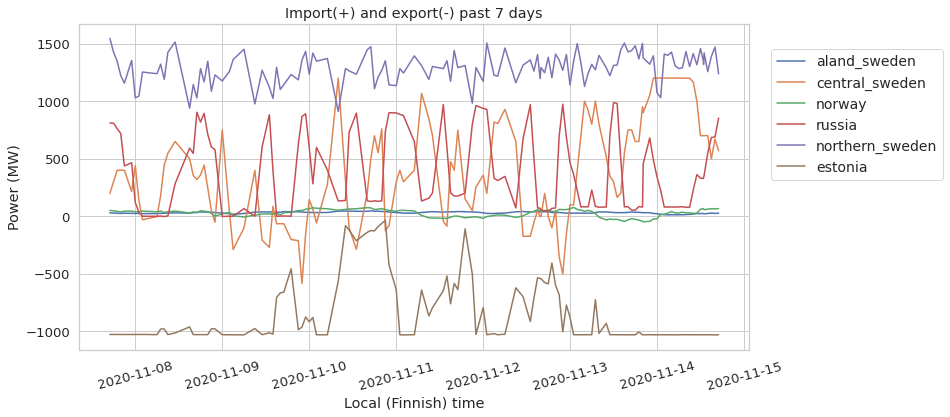

In [8]:
df2 = pd.melt(df, id_vars=['time_local'], value_vars=country_columns,  var_name="Areas")
# Swap signs to be more intuitive 
df2['value'] = df2['value'].multiply(-1)

plt.figure(figsize=(12,6))
ax = sns.lineplot(x='time_local', y='value', hue='Areas', data=df2)
ax.set(xlabel='Local (Finnish) time', ylabel='Power (MW)')
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='lower right', fontsize=font_size)
plt.title('Import(+) and export(-) past '+str(days)+' days')
plt.show()

## Average imported and exported power

Figure below visualizes the average electric power flow between neighboring countries for the past 7 days.

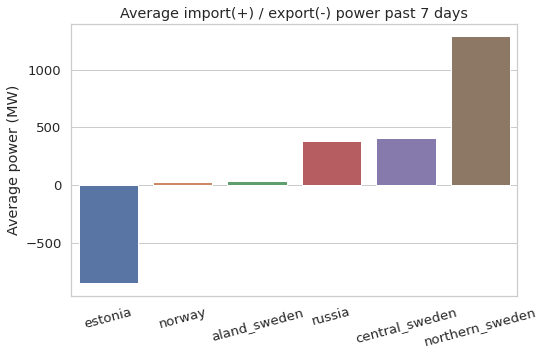

In [9]:
averages = df[country_columns].mean()
# Swap signs to be more intuitive 
import_averages = averages.multiply(-1).sort_values(ascending=True)

plt.figure(figsize=(8,5))
ax = sns.barplot(x=import_averages.index, y=import_averages.values)
ax.set(ylabel = "Average power (MW)")
plt.xticks(rotation=15)
plt.title("Average import(+) / export(-) power past "+str(days)+" days")
plt.show()

## Breakdown of total power production into different components

Figure below visualizes the contribution of different power sources to the total amount. As a clarification, industrial cogeneration refers to the power produced by different industrial power plants which is supplied to the main grid. Cogeneration of district heating on the other hand is the cogenerated district heating supplied by different industrial power plants. Other production includes sources such as condensing power production from nuclear plants and estimated small-scale production from different sources where measurements are not available.

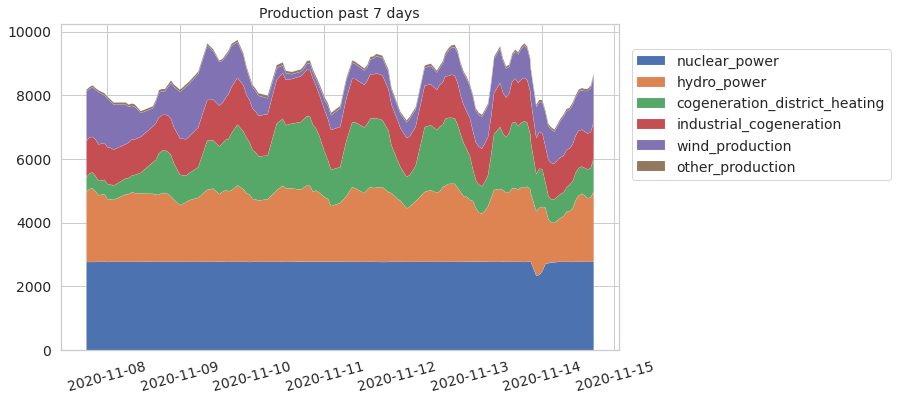

In [10]:
average_sources = df[source_columns].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.stackplot(df['time_local'], 
              df[average_sources.index].to_numpy().T, 
              labels=average_sources.index, 
              linewidths=0.1)
plt.xticks(rotation=15, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(bbox_to_anchor=(1.5, 0.5), loc='lower right', fontsize=font_size)
plt.title("Production past "+str(days)+" days", fontsize=font_size)
plt.show()